# **Содержание**
1. Импорт необходимых библиотек и чтение данных
2. Обработка данных для красных вин
3. Обработка данных для белых вин
4. Обработка объединённого датасета
5. Создание базовой модели
6. Реализация методологии One vs Rest
7. Реализация ансамбля моделей
8. Результаты
9. Альтернативное решение без ограничений
10. Улучшения

# **Импорт данных и библиотек**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.model_selection import train_test_split,cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_absolute_error as mae, r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import QuantileTransformer

import random

**Для возможности повторения результатов, все действия в отчёте будут продемонстрированы на сиде 33**

In [ ]:
random_seed = 33

Первым делом импортируем два датасета
1. Данные о красных винах
2. Данные о белых винах

In [ ]:
red_wine_path = "/content/drive/MyDrive/Датасеты/winequality-red.csv"
white_wine_path = "/content/drive/MyDrive/Датасеты/winequality-white.csv"

red_wine_data = pd.read_csv(red_wine_path,delimiter=";")
white_wine_data = pd.read_csv(white_wine_path,delimiter=";")

Для лучшего понимания датасета выписываем названия колонок

Характеристики

1. fixed acidity - фикс. кислотность
2. volatile acidity - изменчивая кислотность
3. citric acid - лимонная кислота
4. residual sugar - остаточный сахар
5. chlorides - хлориды
6. free sulfur dioxide - свободный диоксид серы
7. total sulfur dioxide - общий диоксид серы
8. density - густота
9. pH -сила кислот
10. sulphates - сульфаты
11. alcohol - % алкоголя
12. quality - уровень качества


Так как существует вероятность, что в данных есть пропущенные значения, выбросы и дубликаты, для корректной обработки таких значений, данные для красных и белых вин обрабатываются раздельно, чтобы не испортить распределения данных

# **Обработка данных для красных вин**

Выводим стандартную информацию о данных

In [ ]:
red_wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
red_wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Явных пропущенных данных нет, поэтому необходимо проверить датасет на наличие пропущенных значений, которые могут отображаться как -1,0 и т.п.

Пишем функцию для вывода кастомного статистического отчёта для набора данных.

В данном отчёте выводятся основные статистические параметры и процентили 2, 25, 50, 75 и 97.
На основе выводимых данных датасет будет оценён на наличие пропущенных значений, которые могут быть не только в виде None, а также оценки наличия выбросов в данных

In [ ]:
# Функция вывода статистических параметров
def show_static_info(df, before_drop=True):
  print("Статистические параметры\n")
  df_val = df.describe(percentiles=[0.02, 0.25, 0.75, 0.97])
  display(df_val)
  # Выводим значения признаков для 3 и 97 процентилей
  if before_drop:
    return df_val.loc["2%", :], df_val.loc["97%", :]

red_wine_2, red_wine_97 = show_static_info(red_wine_data)

Статистические параметры



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
2%,5.600000,0.229600,0.000000,1.400000,0.047000,3.000000,9.000000,0.992580,3.000000,0.440000,9.000000,4.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
97%,12.400000,0.900000,0.660000,6.006000,0.174120,39.000000,127.000000,1.000306,3.600600,1.050000,12.800000,7.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


На основе полученных данных видно, что в датасете присутсвуют выбросы с правой части распределения (ближе к максимальным значениям). Для всех признаков, кроме alcohol, pH и density, разница между максимальным значением и значением 97 процентиля . Разница же между минимальными значениями и 2 процентилем  для большинства данных адекватна. Однако для проверки суждений, отрисовывается распределение данных и boxplot, чтобы лучше оценить наличие выбросов

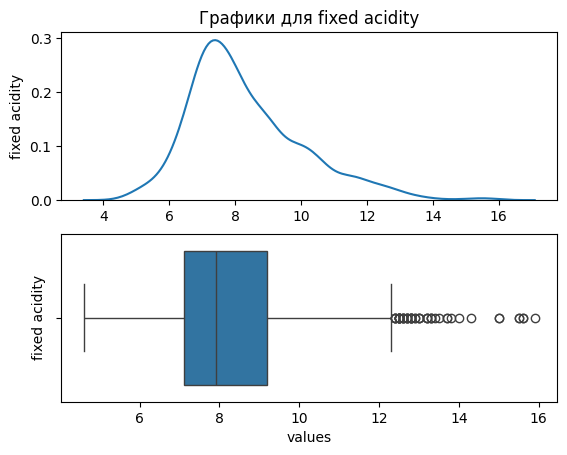

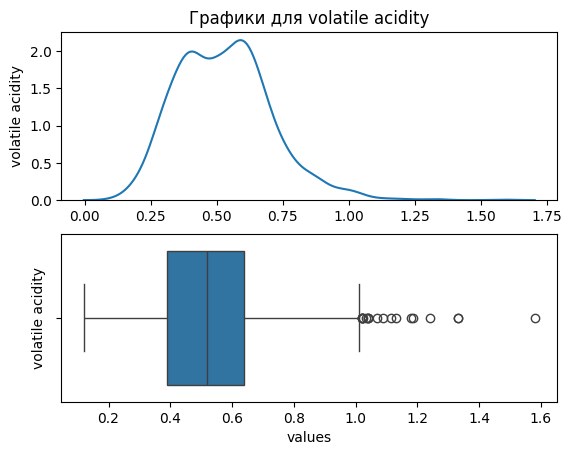

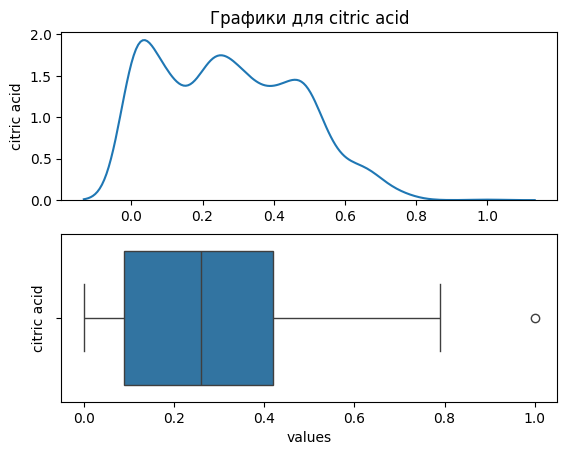

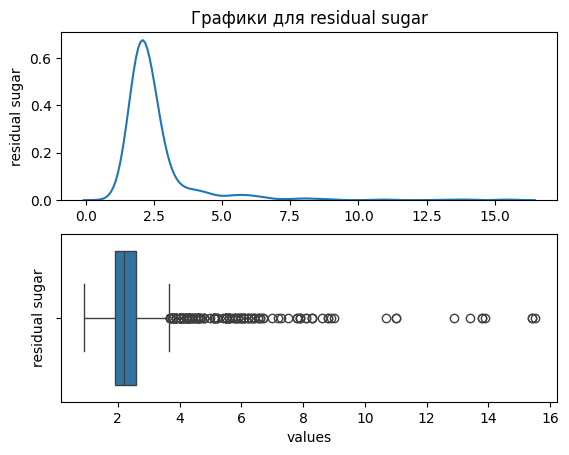

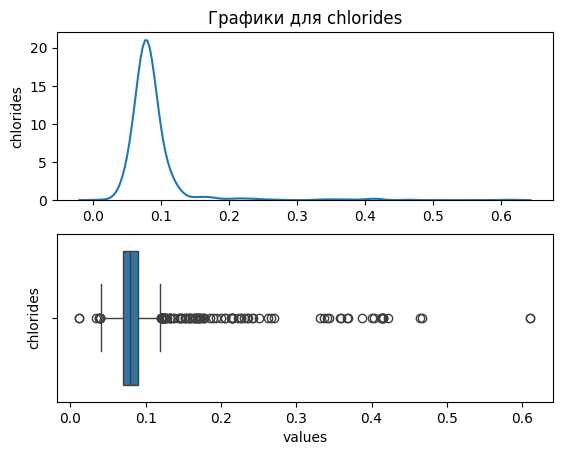

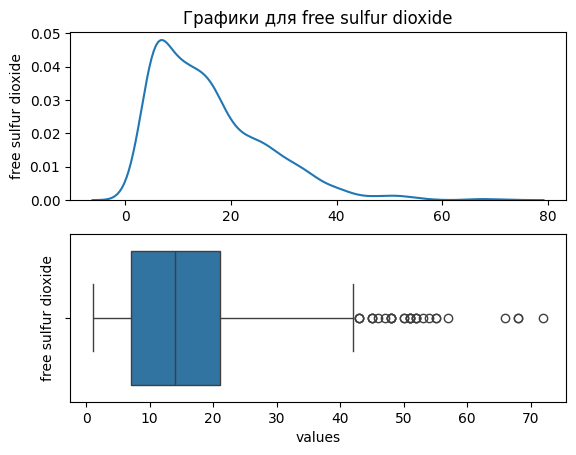

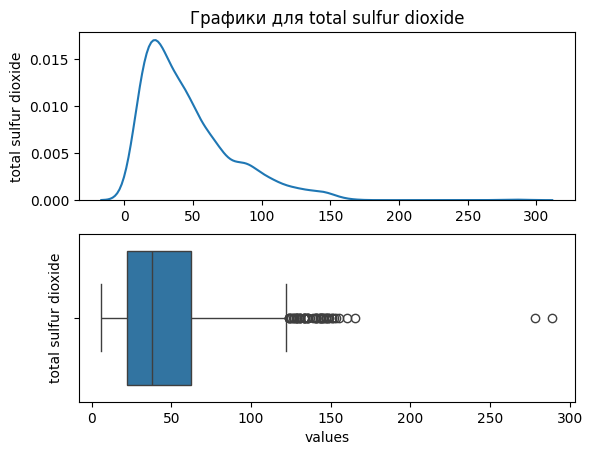

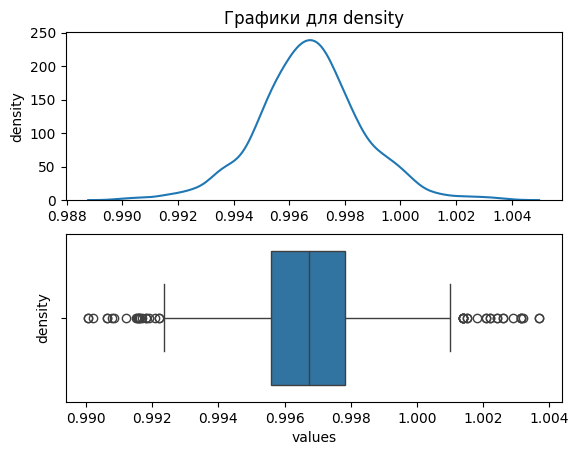

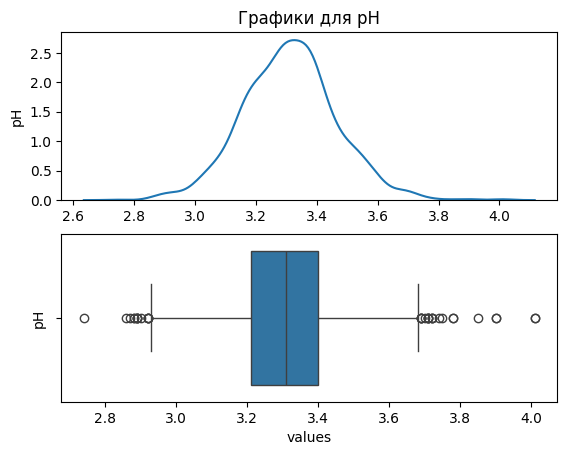

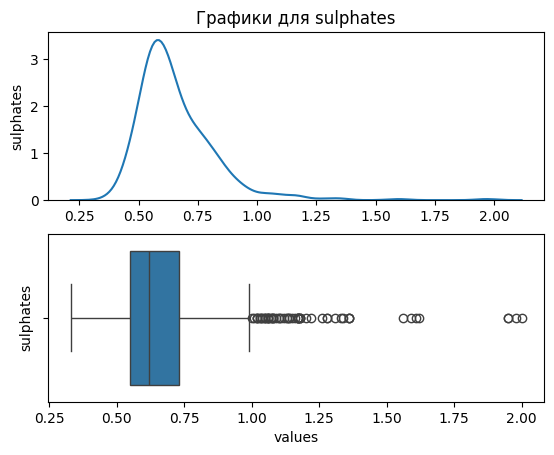

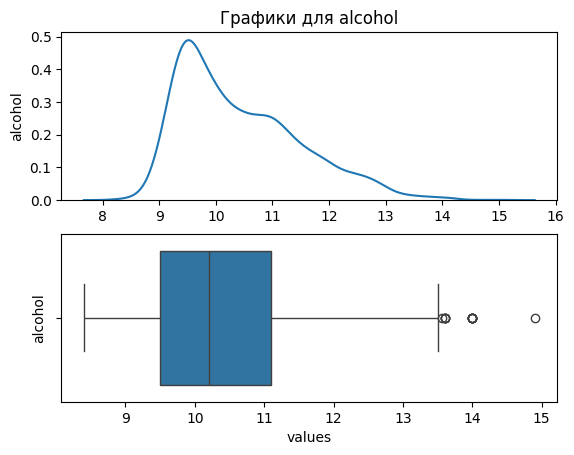

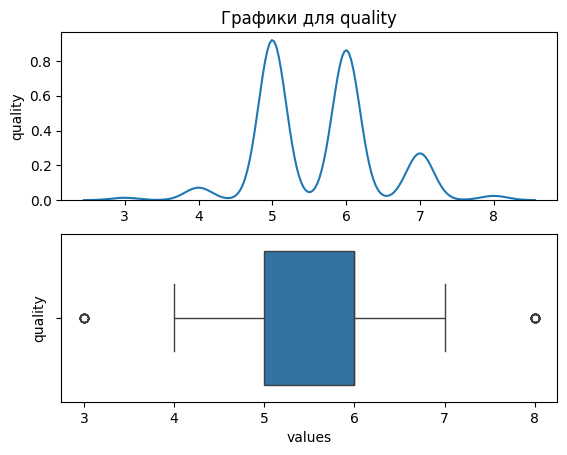

In [ ]:
# Функция вывода распределения данных и boxplot
def show_box_kde(df, columns_name):
  for name in columns_name:
    values = df[name].values
    fig,ax = plt.subplots(2,1)
    # Отрисовываем графики
    sns.kdeplot(values, ax=ax[0])
    sns.boxplot(values,orient="h")
    # Оформляем графика
    ax[0].set_ylabel(name)
    ax[1].set_ylabel(name)
    ax[1].set_xlabel("values")
    ax[0].set_title(f"Графики для {name}")
    plt.show()

show_box_kde(red_wine_data, red_wine_data.columns)

Из графиков выше видно, что признаки chlorides,density и pH имеют выбросы и с левой стороны, поэтому для них по 2 процентилю будут удалены данные. Для правой части значения, практически совпадают с 97 процентилем, поэтому по нему и будет производиться удаление, причём удаление будет производиться по всем параметрам кроме quality и alcohol

Перед удалением необходимо оценить распределение данных по классам , поэтому пишется функция, которая выводит количество экземпляров для каждого класса в наборе данных

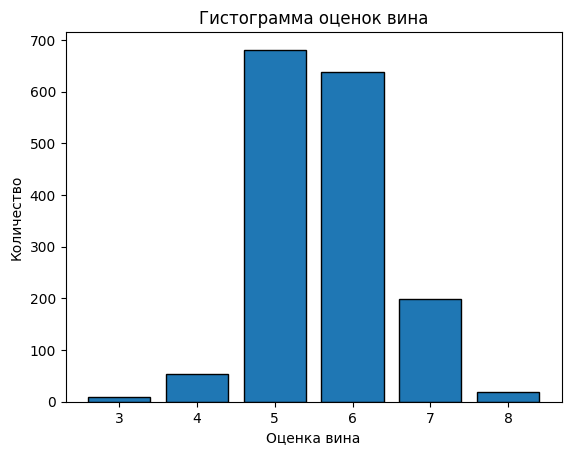

Количество оценок
quality
5          681
6          638
7          199
4           53
8           18
3           10
Name: count, dtype: int64


In [ ]:
# Функция вывода количества экземпляров оценок вин
def show_hist(df):
  # Подсчёт значений
  val = df["quality"].value_counts()
  fig, ax = plt.subplots()
  # Отрисовка данных и настройка графика
  ax.bar(val.index, val.values,edgecolor="black",align="center")
  ax.set_xlabel("Оценка вина")
  ax.set_ylabel("Количество")
  ax.set_title("Гистограмма оценок вина")
  plt.show()

  print("Количество оценок")
  print(df[["quality"]].value_counts())

show_hist(red_wine_data)

Из полученного графика видно, что оценок 3, 4 и 8 очень мало, поэтому для данных оценок выборсы удаляться не будут, для всех остальных значений удаление будет производиться в обычной форме

In [ ]:
# Названия столбцов для правой части выбросов
red_wine_col_names = red_wine_data.columns[:-2]

# Крайние значения для удаления
val_list = list(np.round(red_wine_97[red_wine_col_names].values,4))
# Удаление выбросов правой части
for name,val in zip(red_wine_col_names,val_list):
  red_wine_data = red_wine_data.loc[(red_wine_data[name]<=val) |
                                    (red_wine_data["quality"]<=4) |
                                    (red_wine_data["quality"]==8)]

# Названия столбцов для левой части выбросов
red_wine_col_names = ["chlorides", "density", "pH"]
# Крайние значения для удаления
val_list = list(np.round(red_wine_2[red_wine_col_names].values,4))
# Удаление выбросов левой части
for name,val in zip(red_wine_col_names,val_list):
  red_wine_data = red_wine_data.loc[(red_wine_data[name]>=val) |
                                    (red_wine_data["quality"]<=4) |
                                    (red_wine_data["quality"]==8)]


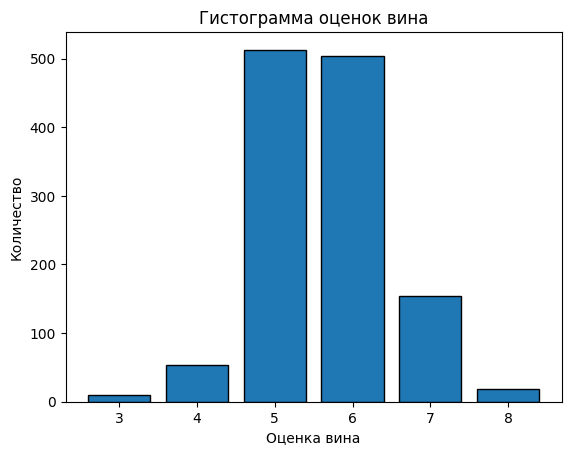

Количество оценок
quality
5          513
6          504
7          154
4           53
8           18
3           10
Name: count, dtype: int64


In [ ]:
show_hist(red_wine_data)

In [ ]:
red_wine_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1252 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1252 non-null   float64
 1   volatile acidity      1252 non-null   float64
 2   citric acid           1252 non-null   float64
 3   residual sugar        1252 non-null   float64
 4   chlorides             1252 non-null   float64
 5   free sulfur dioxide   1252 non-null   float64
 6   total sulfur dioxide  1252 non-null   float64
 7   density               1252 non-null   float64
 8   pH                    1252 non-null   float64
 9   sulphates             1252 non-null   float64
 10  alcohol               1252 non-null   float64
 11  quality               1252 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 127.2 KB


В результате очистка данных было удалено 353 экземпляра данных (22%).

In [ ]:
show_static_info(red_wine_data,before_drop=False)

Статистические параметры



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1252.000000,1252.000000,1252.000000,1252.000000,1252.000000,1252.000000,1252.000000,1252.000000,1252.000000,1252.000000,1252.000000,1252.000000
mean,8.204712,0.522792,0.253658,2.344728,0.081710,14.755591,41.948882,0.996628,3.318427,0.637204,10.383174,5.633387
std,1.458513,0.168131,0.182404,0.816646,0.024173,8.691406,26.698912,0.001541,0.128763,0.128657,0.986112,0.835237
min,4.600000,0.120000,0.000000,1.200000,0.044000,1.000000,6.000000,0.990800,2.740000,0.330000,8.400000,3.000000
2%,6.000000,0.240000,0.000000,1.400000,0.052000,3.000000,9.000000,0.993460,3.060200,0.440000,9.100000,4.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,21.000000,0.995600,3.230000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.240000,2.200000,0.079000,13.000000,35.000000,0.996600,3.320000,0.610000,10.100000,6.000000
75%,9.100000,0.630000,0.400000,2.500000,0.088250,20.000000,56.000000,0.997600,3.400000,0.710000,11.000000,6.000000
97%,11.547000,0.847350,0.590000,4.547000,0.122470,34.000000,106.000000,0.999700,3.560000,0.910000,12.500000,7.000000
max,12.600000,1.580000,1.000000,12.900000,0.610000,42.000000,127.000000,1.001000,3.900000,2.000000,14.000000,8.000000


Для оценки зависимости целевой переменной от признаков, выводится матрица корреляции

Общая матрица корреляции


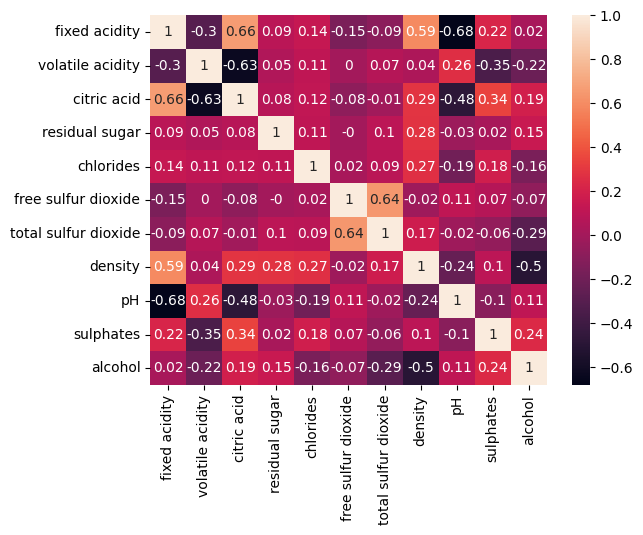


Матрица корреляции параметров и целевого значения


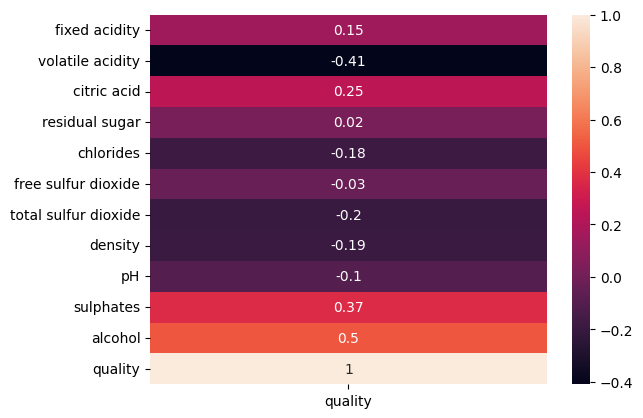

In [ ]:
# Функция для вывода матриц корреляции
def show_corr_matrix(df):
  # Общая матрица корреляции
  corr_matrix = df.corr().round(2)
  print("Общая матрица корреляции")
  sns.heatmap(corr_matrix.loc[:"alcohol",:"alcohol"], annot=True)
  plt.show()
  # Матрица корреляции признаков с целевой переменной
  print("\nМатрица корреляции параметров и целевого значения")
  sns.heatmap(corr_matrix.loc[["quality"]].T, annot=True)

show_corr_matrix(red_wine_data)

Как видно из графиков, некоторые признаки достаточно сильно связаны друг с другом, так как формально являются частями друг друга на химическом уровне, поэтому корреляция и присутсвует

Также видно, что признаки alcohol, sulphates,critic acid и volatile acidity сильнее всего скоррелированы с целевой переменной

Данную корреляцию необходимо будет учесть, если проводить ручной отбор признаков

# **Обработка данных о белых винах**

Для белых вин обработка аналогична красными

In [ ]:
white_wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


Белых вин намного больше, что может негативно сказаться на датасете, так как значения признаков у красных и белых вин могут отличаться, из-за чего итоговый датасет станет несбалансированным, что приведёт к снижению качества предсказаний

In [ ]:
# Статистика белых вин
white_wine_2, white_wine_97 = show_static_info(white_wine_data)

Статистические параметры



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
2%,5.200000,0.130000,0.100000,1.000000,0.023000,7.000000,62.000000,0.989149,2.900000,0.310000,8.700000,4.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
97%,8.600000,0.510000,0.610000,17.200000,0.085090,68.000000,222.000000,0.999600,3.500000,0.750000,12.900000,8.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


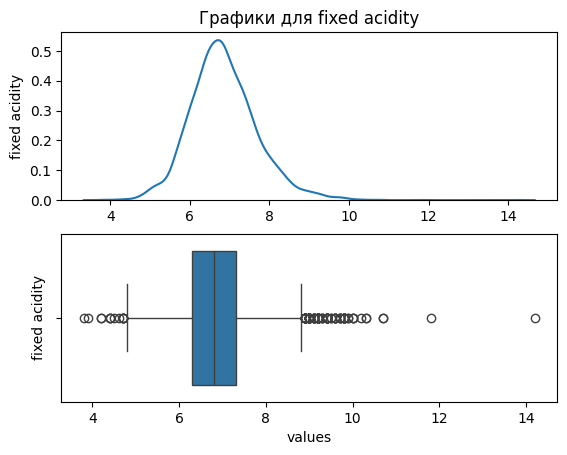

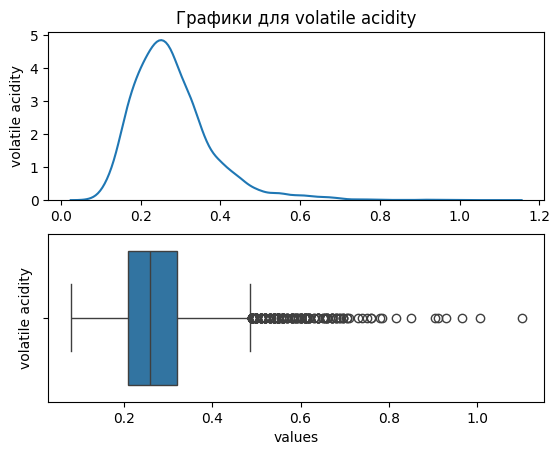

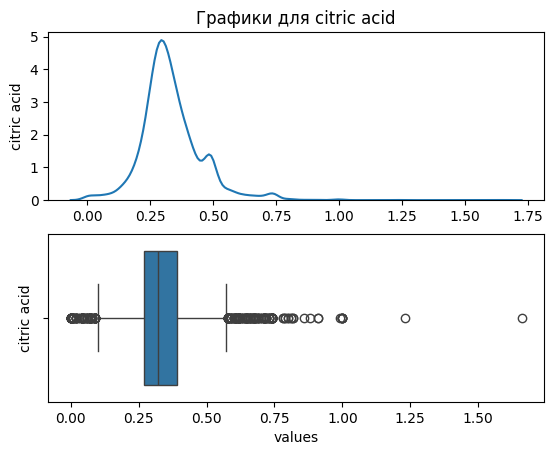

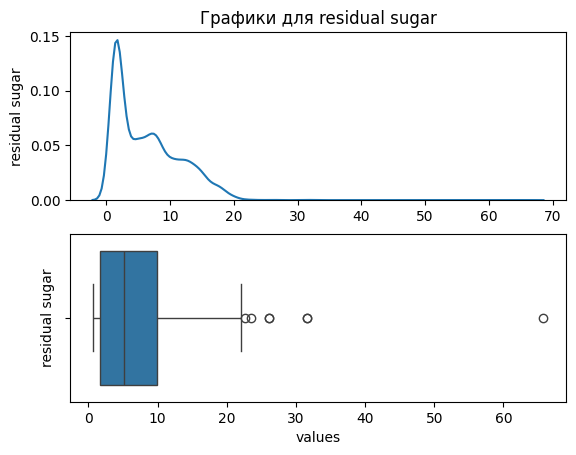

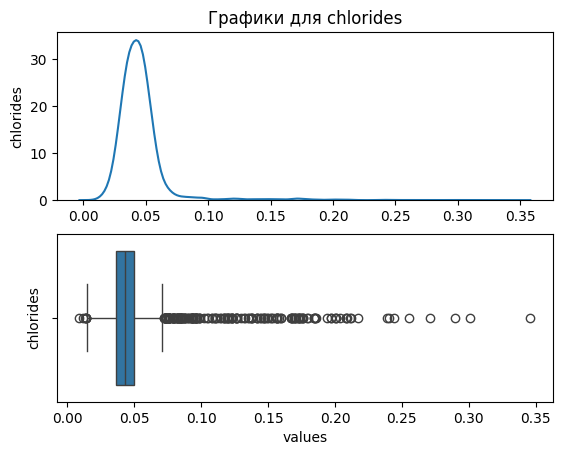

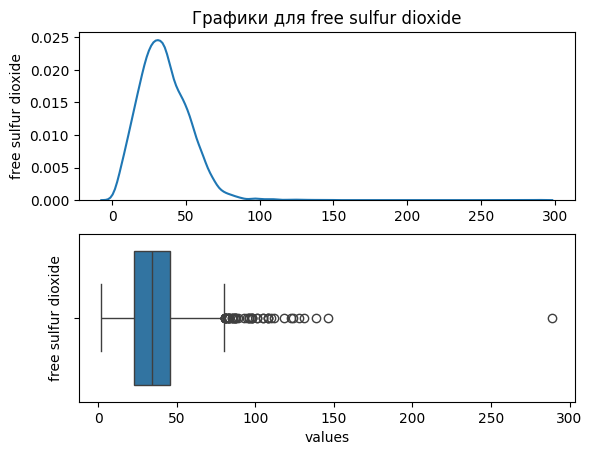

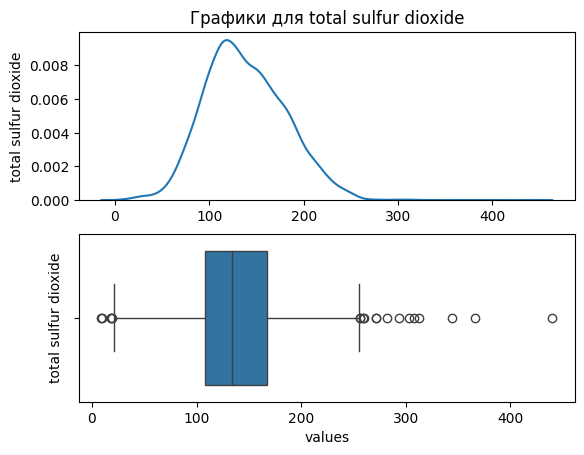

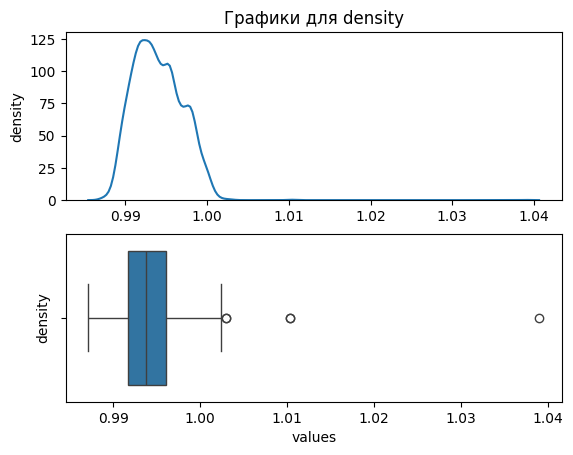

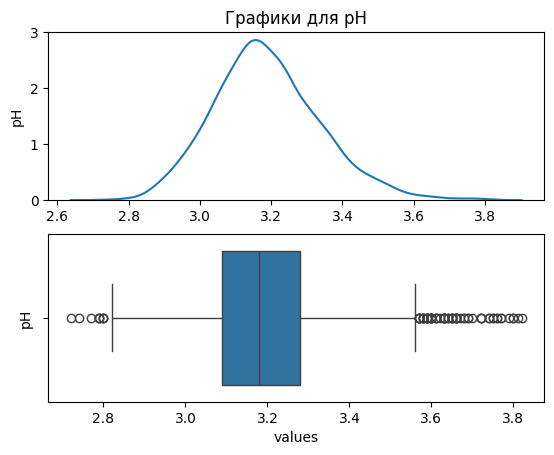

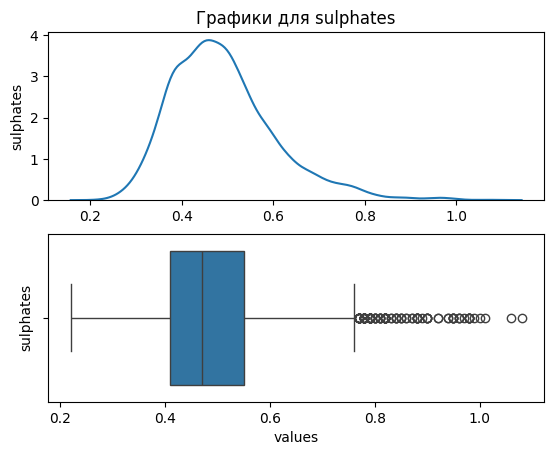

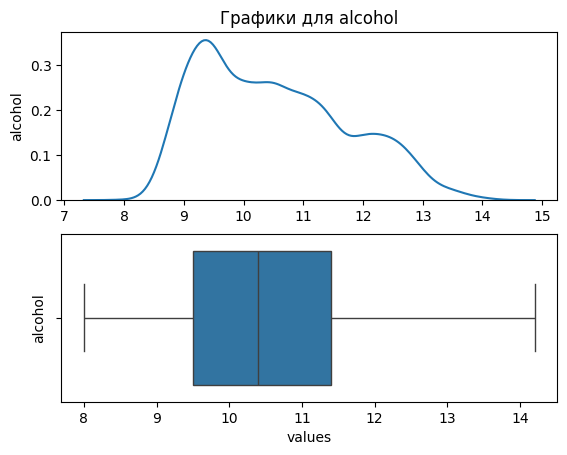

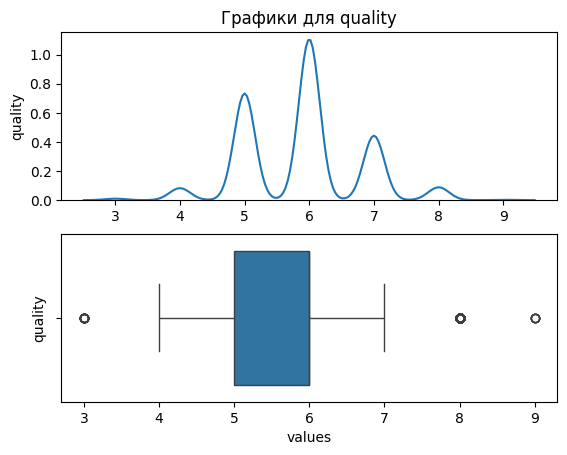

In [ ]:
show_box_kde(white_wine_data, white_wine_data.columns)

Для белых вин выбросы с правой стороны удаляются по всем признакам, с левой стороны по признакам: pH,total sulfur dioxide, chlorides, critic acid и fixed_acidity.

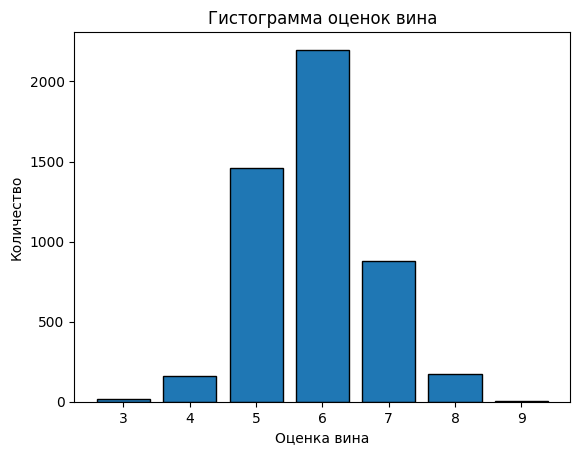

Количество оценок
quality
6          2198
5          1457
7           880
8           175
4           163
3            20
9             5
Name: count, dtype: int64


In [ ]:
show_hist(white_wine_data)

Как видно в наборе данных для белых вин оценок 3, 4, 8 и 9 мало, поэтому для них выбросы не удаляются.

In [ ]:
# Столбцы для удаления
white_wine_col_names = white_wine_data.columns[:-1]

# Крайние значения для удаления
val_list = list(np.round(white_wine_97[white_wine_col_names].values, 4))
# Удаление данных
for name,val in zip(white_wine_col_names, val_list):
  white_wine_data = white_wine_data.loc[(white_wine_data[name] <= val) |
                                    (white_wine_data["quality"] <= 4) |
                                    (white_wine_data["quality"] >= 8) ]

# Столбцы для удаления
white_wine_col_names = ['fixed acidity', 'citric acid',
                        'pH', 'chlorides', 'total sulfur dioxide']
# Крайние значения для удаления
val_list = list(np.round(white_wine_2[white_wine_col_names].values, 4))
# Удаление данных
for name,val in zip(white_wine_col_names, val_list):
  white_wine_data = white_wine_data.loc[(white_wine_data[name] > val) |
                                    (white_wine_data["quality"] <= 4) |
                                    (white_wine_data["quality"] >= 8) ]

In [ ]:
show_static_info(white_wine_data,before_drop = False)

Статистические параметры



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,3511.000000,3511.000000,3511.000000,3511.000000,3511.000000,3511.000000,3511.000000,3511.000000,3511.000000,3511.000000,3511.000000,3511.000000
mean,6.834449,0.271201,0.325491,5.920393,0.043213,34.389063,136.551410,0.993748,3.189117,0.482996,10.571565,5.907149
std,0.734627,0.089817,0.093984,4.471317,0.011718,15.596077,38.546252,0.002625,0.130334,0.100968,1.144681,0.944278
min,3.900000,0.080000,0.000000,0.700000,0.013000,2.000000,10.000000,0.987130,2.830000,0.230000,8.000000,3.000000
2%,5.500000,0.130000,0.150000,1.000000,0.026000,8.000000,70.000000,0.989364,2.950000,0.310000,8.800000,4.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,24.000000,108.000000,0.991655,3.100000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.310000,5.000000,0.042000,33.000000,132.000000,0.993500,3.180000,0.470000,10.500000,6.000000
75%,7.300000,0.320000,0.370000,8.900000,0.049000,45.000000,164.000000,0.995665,3.280000,0.540000,11.400000,6.000000
97%,8.300000,0.460000,0.510000,15.185000,0.063000,62.000000,210.000000,0.998600,3.450000,0.700000,12.700000,8.000000
max,11.800000,1.100000,0.880000,17.550000,0.290000,289.000000,440.000000,1.000600,3.720000,0.950000,14.000000,9.000000


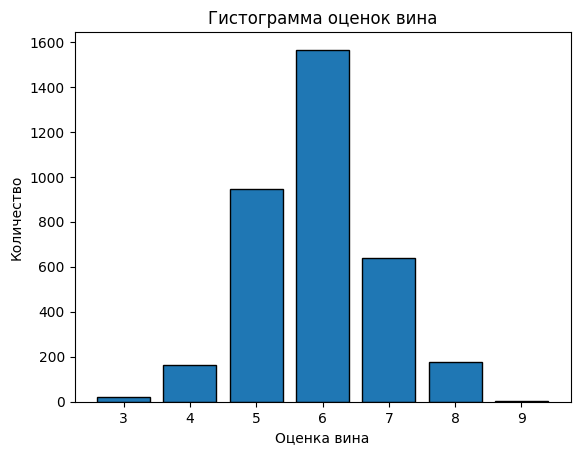

Количество оценок
quality
6          1565
5           944
7           639
8           175
4           163
3            20
9             5
Name: count, dtype: int64


In [ ]:
show_hist(white_wine_data)

Общая матрица корреляции


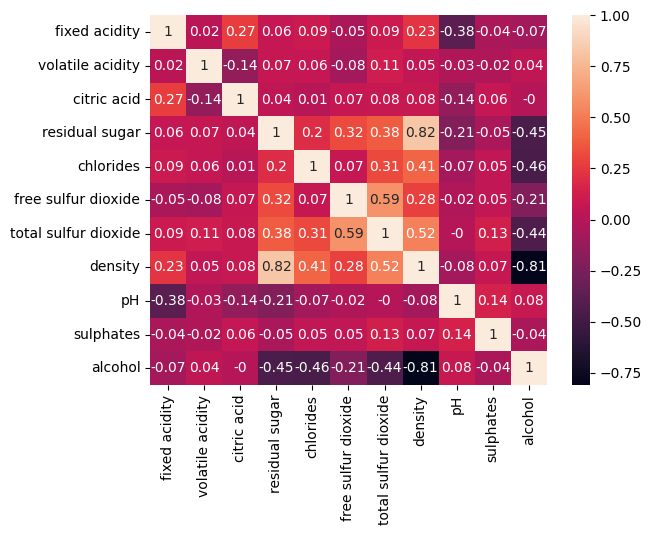


Матрица корреляции параметров и целевого значения


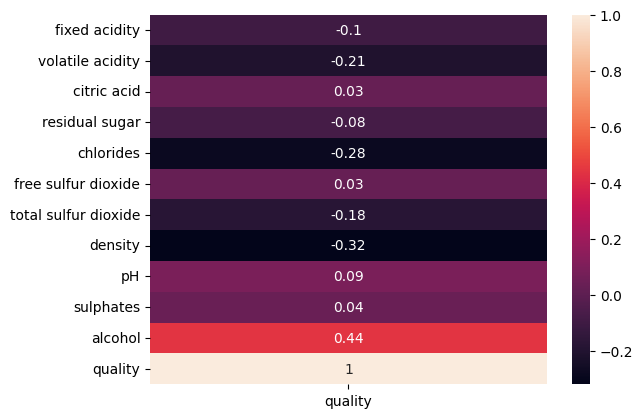

In [ ]:
show_corr_matrix(white_wine_data)

Для белых вин зависимость между признаками и оценкой отличается от тех, что были у красных, значимую корреляцию с целевой переменной имеют признаки alcohol, density и chlorides.

# **Общий датасет**

Данные объединяются для в один датасет

In [ ]:
wine_data = pd.concat((red_wine_data, white_wine_data))
wine_data.reset_index(drop=True,inplace=True)

In [ ]:
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4763 entries, 0 to 4762
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4763 non-null   float64
 1   volatile acidity      4763 non-null   float64
 2   citric acid           4763 non-null   float64
 3   residual sugar        4763 non-null   float64
 4   chlorides             4763 non-null   float64
 5   free sulfur dioxide   4763 non-null   float64
 6   total sulfur dioxide  4763 non-null   float64
 7   density               4763 non-null   float64
 8   pH                    4763 non-null   float64
 9   sulphates             4763 non-null   float64
 10  alcohol               4763 non-null   float64
 11  quality               4763 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 446.7 KB


После объединения данных необходимо проверить наличие дубликатов, так как данные из двух наборов могли совпасть, также в каждом из наборов могли быть дубликаты, которые в дальнейшем могу исказить результаты обучения моделей.

In [ ]:
# Подсчёт количества дубликатов
duplicated_numb = wine_data.duplicated().value_counts()
display(duplicated_numb)
# Удаление дубликатов
wine_data.drop_duplicates(keep="first",inplace=True)

,count
False,3920
True,843


In [ ]:
wine_data.loc[:,:"alcohol"].duplicated().value_counts()

,count
False,3920


Суммарно было найдено 843 дубликата, которые были удалены из данных

Статистические параметры



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,3920.000000,3920.000000,3920.000000,3920.000000,3920.000000,3920.000000,3920.000000,3920.000000,3920.000000,3920.000000,3920.000000,3920.000000
mean,7.200523,0.340339,0.306704,4.652997,0.053591,28.760969,110.022959,0.994385,3.229296,0.524867,10.566003,5.808673
std,1.172316,0.163154,0.128586,3.925839,0.024049,16.612991,54.832935,0.002672,0.141219,0.128607,1.097496,0.932598
min,3.900000,0.080000,0.000000,0.700000,0.013000,1.000000,6.000000,0.987130,2.740000,0.230000,8.000000,3.000000
2%,5.600000,0.140000,0.000000,1.000000,0.026000,4.000000,12.000000,0.989480,2.960000,0.320000,8.900000,4.000000
25%,6.400000,0.230000,0.240000,1.800000,0.038000,16.000000,71.750000,0.992150,3.130000,0.430000,9.600000,5.000000
50%,7.000000,0.290000,0.310000,2.600000,0.047000,27.000000,114.000000,0.994600,3.220000,0.510000,10.400000,6.000000
75%,7.700000,0.400000,0.380000,7.000000,0.065000,39.000000,149.250000,0.996500,3.330000,0.600000,11.300000,6.000000
97%,10.300000,0.735000,0.540000,14.400000,0.102000,61.000000,206.000000,0.998800,3.500000,0.800000,12.700000,8.000000
max,12.600000,1.580000,1.000000,17.550000,0.610000,289.000000,440.000000,1.001000,3.900000,2.000000,14.000000,9.000000


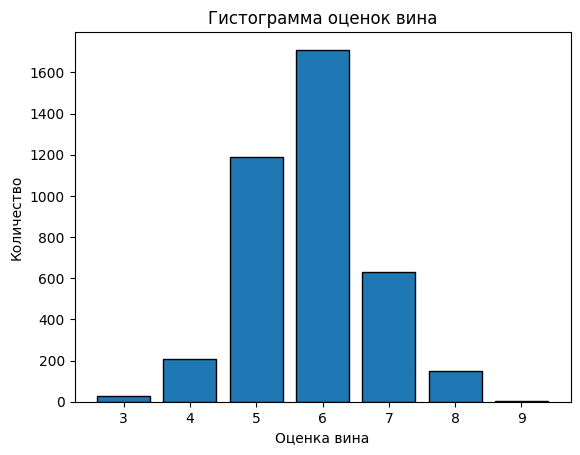

Количество оценок
quality
6          1710
5          1190
7           631
4           206
8           148
3            30
9             5
Name: count, dtype: int64


In [ ]:
# Вывод ключевых параметров датасета
wine_data.reset_index(drop=True)
show_static_info(wine_data)
show_hist(wine_data)



---


**Из-за условий использования только библиотек pandas, sklearn и numpy , основная реализация будет производиться на основе методов из данных библиотек, либо реализовываться вручную**


---



Так как данные несбалансированы, было принято решение прорядить наиболее частые оценки, а именно 5 и 6, для этого была написана функция, которая случайным образом удаляет экземпляры данных с указанными целевыми переменными

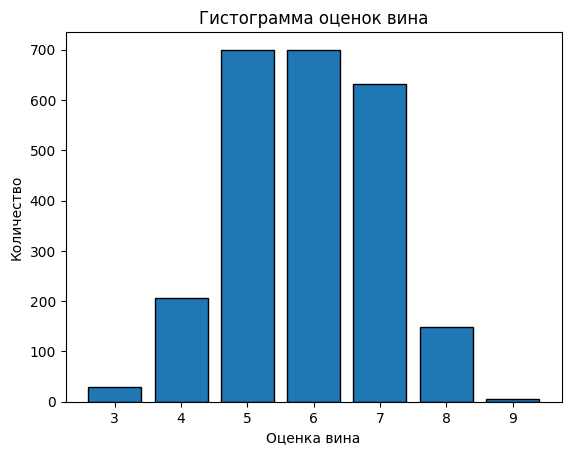

Количество оценок
quality
5          700
6          700
7          631
4          206
8          148
3           30
9            5
Name: count, dtype: int64


In [ ]:
# Функция для удаления данных
def delete_data(index_list, count=700):
  # Обход переданных оценок
  for index in index_list:
    # Выбор данных с указанными оценками
    index_data = wine_data.loc[wine_data["quality"]==index]
    len_index = len(index_data) - count
    # Случайный выбор данных для удаления
    del_index = random.sample(list(index_data.index), len_index)
    # Удаление данных
    wine_data.drop(del_index, inplace=True)
delete_data([6,5],700)
show_hist(wine_data)
wine_data.reset_index(drop=True,inplace=True)

На основе проведённых исследований было выяснено, что при проряживании данных до 700 экзмепляров в каждом классе, модели показывают лучшие результаты, поэтому прореживание частых оценок производится до 700 экзмепляров
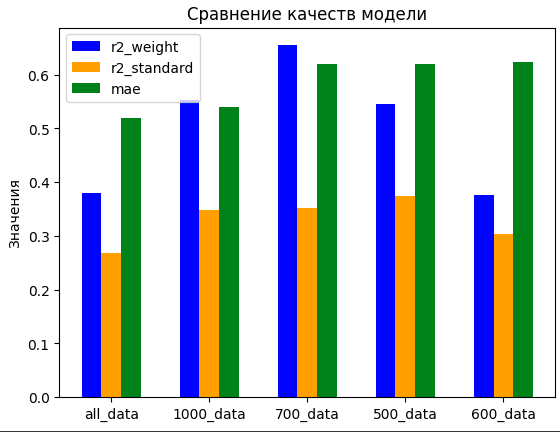

Разбиваем датасет на тестовую и обучающую выборку в соотношении 80 к 20, при этом соблюдая соотношение целевых переменных в исходных данных, чтобы экземпляры со всеми целевыми значениями попали в тестовую выборку

In [ ]:
y_data = wine_data["quality"]
x_data = wine_data.drop(columns=["quality"])

x_train, x_test, y_train, y_test = train_test_split(x_data,y_data,test_size=0.2, random_state=random_seed, stratify=y_data)

Модели нейронных сетей лучше работают на стандартизованных или нормальизованных данных, на основе экспериментов было выяснено, что базовая модель лучше работает с данными после квантильных преобразований, поэтому для преобразования данных будут использоваться именно они

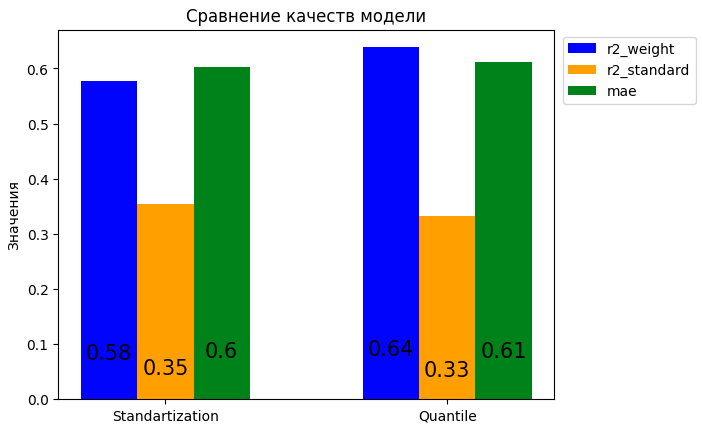

Также был проверен метод PCA для понижения размерности данных. В результате проверки, данный метод показал себя плохо, поэтому было принято решение оставить квантильные преобразования
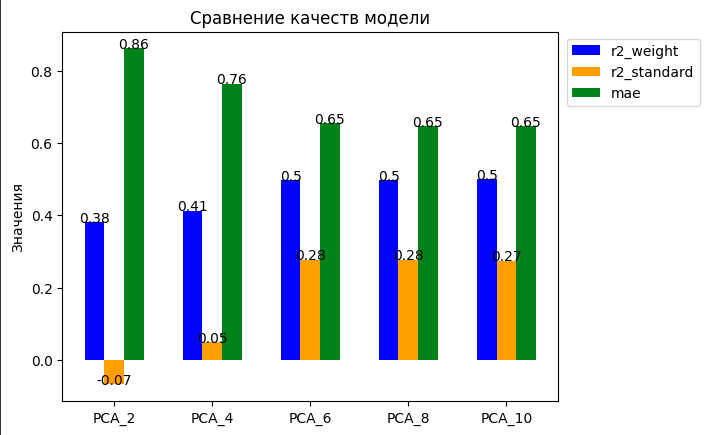

In [ ]:
quant_transfor = QuantileTransformer(n_quantiles=200,output_distribution="normal",random_state=random_seed)

x_train = quant_transfor.fit_transform(x_train)
x_test = quant_transfor.transform(x_test)

# **Создание модели**

Так как по условию ТЗ необходимо использовать только 3 библиотеки, нейронная сеть берётся из библиотеки sklearn. Реализация с использованием нейронных сетей там только одна(MLPClassifier), поэтому использоваться будет именно она

Так как данные несбалансированные, R2 будет считаться в двух версиях, во взвешенной (каждым тестовым данным выдаётся определённый вес) и обычный, где все данные имеют один вес

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight

# Вычисляем вес тестовых данных
sample_weights = compute_sample_weight(class_weight="balanced", y=y_test)

Так как будет создано несколько моделей, для сравнения их качества создаётся датафрейм с 3 столбцами

In [ ]:
# Создаём датафрейм для записи результатов модели
result = pd.DataFrame(columns=["r2_score->1", "r2_standard->1", "mae -> 0"])

Для каждой модели необходимо будет сохранять результаты её обучения, поэтому создаётся функция, которая вычисляет все метрики и сохраняет их

In [ ]:
# Функция для тестирования модели
def predict_data(model, x_test, method_name = "Standard", save_data = False):
  predict = model.predict(x_test)

  # Вычисляем метрики
  r2_weight = r2_score(y_test, predict, sample_weight=sample_weights)
  r2_standard = r2_score(y_test, predict)
  mae_val = mae(y_test, predict)

  # Выводим результаты тестирования модели
  values = [[r2_standard, r2_weight, mae_val]]
  col_names = ["r2_standard -> 1", "r2_weight -> 1", "mae -> 0"]
  metrics_df = pd.DataFrame(np.array(values), columns=col_names)
  display(metrics_df)

  # Сохраняем результаты тестирования
  if save_data:
    result.loc[method_name] = values[0]

  return predict,r2_weight,r2_standard, mae_val


Для оценки предсказаний моделей пишется функция, которая выводит таблицу с количеством сгенерированных предсказаний по классам, а также матрицу ошибок, на основе которой оценивается адекватность работы модели

In [ ]:
def show_count_pred(predict, classes=[]):
  y_predict = pd.DataFrame(predict,columns=["values"])
  y_pred_count = y_predict.value_counts()
  y_pred_count = y_pred_count.reset_index().set_index(["values"])
  y_real_count = y_test.value_counts()
  y_merge = pd.concat([y_real_count,y_pred_count],axis=1)

  y_merge = y_merge.set_axis(["Реальные", "Сгенерированные"],axis=1)
  display(y_merge)

  if len(classes) != 0:
    cm = confusion_matrix(y_test, y_predict, labels=classes)
    disp = ConfusionMatrixDisplay(cm, display_labels=classes)
    disp.plot()
    plt.show()


В sklearn нейронная сеть для классификации реализовать можно только с помощью метода MLPClassifier

1. Так как все данные проходят через квантильные преобразования, а также на выходном слое выводится вектор вероятностей классов, в качестве функции активации используется сигмоида, значения которой расположены в диапазоне от 0 до 1

2. Настроить функцию ошибки нельзя, она стандартно идёт как ошибка кросс-энтропии. Так как данная ошибка часто применяется в многоклассовой классификации и показывает хорошие результаты сходимости, данная ошибка удовлетворяет поставленной задаче

3. Для обучения используется стахостический градиентный спуск, который обновляет градиент после каждого прохода подвыборки датасета. Для обучения используется метод fit

**Модель**

1. В качестве модели в методе MLPClassifier используется персептрон, у которого можно настраивать количество слоёв. В baseline модели использовалось два слоя на 64 и 32 нейрона. R2 метрика у ней показала 0.2, mae 0.59, на основе данных величин и оценивались последующие модели
2. В результате экспериментов наилучшим образом себя показала модель из 4 слоёв с количестом нейронов 128 - 256 - 128 - 64. Выбор количества нейронов строился по принципу разложения основных признаков на множество скрытых признаков: слои 128 - 256 преобразуют данные в многомерное пространство, которое лучше описывает исходные данные. Вторая часть модели 128 - 64 сжимает данные признаки в пространство меньше размерности, чтобы выделить наиболее значимые признаки и на их основе сделать предсказание
3. Так как экземпляры данных сильно похожи друг на друга, размер батчей устанавливается небольшим(32), чтобы модель лучше обучалась на каждых экземплярах данных
4. Количество итераций устанавливается в 300, так как после данного числа итераций обучение модели практически не даёт прироста в метриках и приводит к переобучению
5. Основным недостатком модели является невозможность указать веса для целевых переменных, которые указывали бы модели, что более редкие классы должны сильнее влиять на веса модели, нежели частые классы.

In [ ]:
model_stand = MLPClassifier(hidden_layer_sizes=(128,256,128,64),
                            activation="logistic",
                            solver="adam",
                            max_iter=300,
                            random_state=random_seed,
                            batch_size=32,
                            verbose=True)
model_stand.fit(x_train,y_train)

Iteration 1, loss = 1.40528888
Iteration 2, loss = 1.35023048
Iteration 3, loss = 1.34405944
Iteration 4, loss = 1.25809708
Iteration 5, loss = 1.17949998
Iteration 6, loss = 1.15812155
Iteration 7, loss = 1.15303280
Iteration 8, loss = 1.15395106
Iteration 9, loss = 1.14791003
Iteration 10, loss = 1.14534884
Iteration 11, loss = 1.14390880
Iteration 12, loss = 1.14083137
Iteration 13, loss = 1.14256760
Iteration 14, loss = 1.13735843
Iteration 15, loss = 1.13740502
Iteration 16, loss = 1.13530169
Iteration 17, loss = 1.13147163
Iteration 18, loss = 1.13364005
Iteration 19, loss = 1.13273403
Iteration 20, loss = 1.12609083
Iteration 21, loss = 1.12601254
Iteration 22, loss = 1.12627476
Iteration 23, loss = 1.12525760
Iteration 24, loss = 1.11878068
Iteration 25, loss = 1.11955995
Iteration 26, loss = 1.12031929
Iteration 27, loss = 1.11775318
Iteration 28, loss = 1.11519817
Iteration 29, loss = 1.11423377
Iteration 30, loss = 1.11474853
Iteration 31, loss = 1.11580210
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', batch_size=32,
              hidden_layer_sizes=(128, 256, 128, 64), max_iter=300,
              random_state=33, verbose=True)

,r2_standard -> 1,r2_weight -> 1,mae -> 0
0,0.312077,0.656857,0.632231


,r2_score->1,r2_standard->1,mae -> 0
OVR_model,0.208395,0.636555,0.659091
4_layer_model,0.312077,0.656857,0.632231


,Реальные,Сгенерированные
5,140,148.0
6,140,168.0
7,126,133.0
4,41,23.0
8,30,12.0
3,6,NaN
9,1,NaN


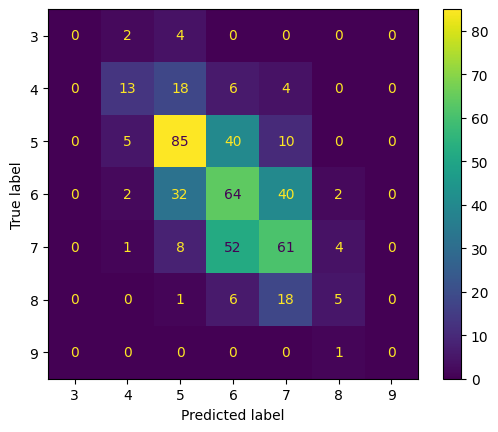

In [ ]:
predict_normal,r2_w_all,r2_all,mae_val = predict_data(model_stand,x_test,"4_layer_model",True)
display(result)
show_count_pred(predict_normal,model_stand.classes_)

Из полученных результатов видно, что модель практически не улучшилась по метрике MAE, однако сильно улучшила метрку R2

На основе матрицы ошибок можно понять, что модель плохо распознаёт классы 8 и 4, вообще не классифицирует наиболее редкие классы 3 и 9. А также допускает много ошибок при классификации классов 5, 6 и 7. Что говорит о том, что данные сильно похожи друг на друга, и модель не может выделить правила, по которым разделять данные

Основываясь на полученные результатах логично предположить, что обучение нескольких моделей для каждого класса может улучшить результаты для оценок 4-7. Проблему же с оценками 3, 8 и 9 это скорее всего не решит, так как данных слишком мало

# **OVR**

В sklearn есть метод, позволяющий обучать модели для многоклассовой классификации по методологии One vs Rest, когда модель обучается классифицировать два класса (определённый класс из исходных данных и все остальные классы как единый объект)

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

Для каждого класса задаётся модель классификации, так как задача разделения данных на 2 класса легче, чем разделение на 7, то было принято решение сделать модели из 3 слоёв, убрав крайний слой, а также уменьшив количество нейронов в 2 раза

In [ ]:
model_ovr = MLPClassifier(hidden_layer_sizes=(64,128,64),
                            activation="logistic",
                            solver="adam",
                            max_iter=300,
                            random_state=random_seed,
                            batch_size=32)
model_stand.fit(x_train,y_train)
ovr = OneVsRestClassifier(model_ovr,verbose=1)
ovr.fit(x_train,y_train)

Iteration 1, loss = 1.58943779
Iteration 2, loss = 1.52195704
Iteration 3, loss = 1.52255001
Iteration 4, loss = 1.51069218
Iteration 5, loss = 1.38190776
Iteration 6, loss = 1.30619017
Iteration 7, loss = 1.27624442
Iteration 8, loss = 1.25577919
Iteration 9, loss = 1.25673337
Iteration 10, loss = 1.24829177
Iteration 11, loss = 1.24542966
Iteration 12, loss = 1.24287770
Iteration 13, loss = 1.24645703
Iteration 14, loss = 1.24219906
Iteration 15, loss = 1.24381617
Iteration 16, loss = 1.23862359
Iteration 17, loss = 1.23745439
Iteration 18, loss = 1.23849855
Iteration 19, loss = 1.23902862
Iteration 20, loss = 1.23511523
Iteration 21, loss = 1.24484445
Iteration 22, loss = 1.23767120
Iteration 23, loss = 1.23474984
Iteration 24, loss = 1.23722994
Iteration 25, loss = 1.23455480
Iteration 26, loss = 1.23990331
Iteration 27, loss = 1.23168852
Iteration 28, loss = 1.23540300
Iteration 29, loss = 1.23130562
Iteration 30, loss = 1.22920254
Iteration 31, loss = 1.22699440
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


OneVsRestClassifier(estimator=MLPClassifier(activation='logistic',
                                            batch_size=32,
                                            hidden_layer_sizes=(64, 128, 64),
                                            max_iter=300, random_state=33),
                    verbose=1)

,r2_standard -> 1,r2_weight -> 1,mae -> 0
0,0.208395,0.636555,0.659091


,r2_score->1,r2_standard->1,mae -> 0
OVR_model,0.208395,0.636555,0.659091


,Реальные,Сгенерированные
5,140,169.0
6,140,89.0
7,126,177.0
4,41,30.0
8,30,19.0
3,6,NaN
9,1,NaN


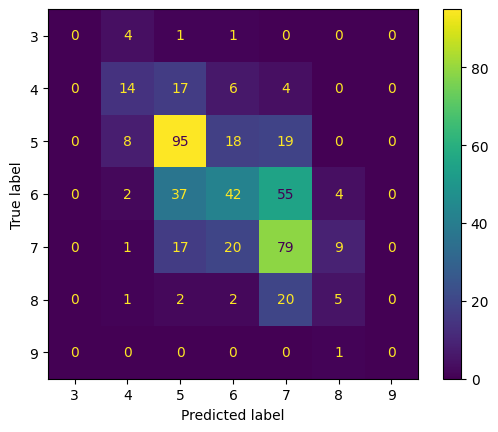

In [ ]:
predict_normal,r2_stand, r2_w,mae_values = predict_data(ovr,x_test,"OVR_model",save_data=True)
display(result)
show_count_pred(predict_normal,[3, 4, 5, 6, 7, 8, 9])

В результате обучения различных моделей, качество обычной R2 упало, модель стала чаще путать классы 5,6 и 7

Так как модели часто путают классы 4-7, было принято решение обучить 3 модели - модель для всех классов, модели для нечётных и чётных классов.

# **Half & Half & ALL**

Для новых моделей необходимо сформировать новые датасеты

In [ ]:
# Создаём новые переменные для данных
y_data = wine_data["quality"]
x_data = wine_data.drop(columns=["quality"])

In [ ]:
# Делим данные на тестовую и тренировочную выборку
x_train, x_test, y_train, y_test = train_test_split(x_data,y_data,test_size=0.2, random_state=random_seed, stratify=y_data)

x_train["quality"] = y_train

# Данные для новых моделей
x_train_odd = x_train.copy()
x_train_even = x_train.copy()

# Данные с чётными классами
x_train_even.loc[x_train_even["quality"] % 2 != 0,"quality"] = 0
y_train_even = x_train_even["quality"]
x_train_even.drop(columns=["quality"],inplace=True)
# Данные с нечётными классами
x_train_odd.loc[x_train_odd["quality"] % 2 == 0,"quality"] = 0
y_train_odd = x_train_odd["quality"]
x_train_odd.drop(columns=["quality"],inplace=True)

x_train.drop(columns=["quality"],inplace=True)

In [ ]:
# Вычисляем веса экземпляров тестовой выборки
sample_weights = compute_sample_weight(class_weight="balanced", y=y_test)

In [ ]:
# Инициализация квантильных преобразований
quant_transfor = QuantileTransformer(n_quantiles=200,output_distribution="normal",random_state=random_seed)

# Преобразования данных
x_train = quant_transfor.fit_transform(x_train)
x_test = quant_transfor.transform(x_test)

x_train_odd = quant_transfor.transform(x_train_odd)
x_train_even = quant_transfor.transform(x_train_even)

Инициализируем 3 модели, первая будет основной, она будет обучаться на всех данных, вторая будет обучаться только на данных с нечётными оценками, а третья только на данных с чётными

In [ ]:
# Обучение моделей
print("Обучаем обычные классы")
model = MLPClassifier(hidden_layer_sizes=(128,256,128,64),
                            activation="logistic",
                            solver="adam",
                            max_iter=300,
                            random_state=random_seed,
                            batch_size=32,
                            verbose=True)
model.fit(x_train,y_train)

print("Обучаем нечётные классы")
model_odd = MLPClassifier(hidden_layer_sizes=(128,256,128),
                            activation="logistic",
                            solver="adam",
                            max_iter=100,
                            random_state=random_seed,
                            batch_size=32,
                            verbose=True)
model_odd.fit(x_train_odd,y_train_odd)

print("Обучаем чётные классы")
model_even = MLPClassifier(hidden_layer_sizes=(128,256,128),
                            activation="logistic",
                            solver="adam",
                            max_iter=100,
                            random_state=random_seed,
                            batch_size=32,
                            verbose=True)
model_even.fit(x_train_even,y_train_even)

Обучаем обычные классы
Iteration 1, loss = 1.58943779
Iteration 2, loss = 1.52195704
Iteration 3, loss = 1.52255001
Iteration 4, loss = 1.51069218
Iteration 5, loss = 1.38190776
Iteration 6, loss = 1.30619017
Iteration 7, loss = 1.27624442
Iteration 8, loss = 1.25577919
Iteration 9, loss = 1.25673337
Iteration 10, loss = 1.24829177
Iteration 11, loss = 1.24542966
Iteration 12, loss = 1.24287770
Iteration 13, loss = 1.24645703
Iteration 14, loss = 1.24219906
Iteration 15, loss = 1.24381617
Iteration 16, loss = 1.23862359
Iteration 17, loss = 1.23745439
Iteration 18, loss = 1.23849855
Iteration 19, loss = 1.23902862
Iteration 20, loss = 1.23511523
Iteration 21, loss = 1.24484445
Iteration 22, loss = 1.23767120
Iteration 23, loss = 1.23474984
Iteration 24, loss = 1.23722994
Iteration 25, loss = 1.23455480
Iteration 26, loss = 1.23990331
Iteration 27, loss = 1.23168852
Iteration 28, loss = 1.23540300
Iteration 29, loss = 1.23130562
Iteration 30, loss = 1.22920254
Iteration 31, loss = 1.226

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.17076856
Iteration 2, loss = 1.14209682
Iteration 3, loss = 1.08046476
Iteration 4, loss = 0.98996383
Iteration 5, loss = 0.97158588
Iteration 6, loss = 0.96280934
Iteration 7, loss = 0.96563380
Iteration 8, loss = 0.95426625
Iteration 9, loss = 0.95415601
Iteration 10, loss = 0.95781464
Iteration 11, loss = 0.95702270
Iteration 12, loss = 0.95251351
Iteration 13, loss = 0.94869712
Iteration 14, loss = 0.95023792
Iteration 15, loss = 0.95304321
Iteration 16, loss = 0.95236118
Iteration 17, loss = 0.95094142
Iteration 18, loss = 0.95063961
Iteration 19, loss = 0.94945824
Iteration 20, loss = 0.95059309
Iteration 21, loss = 0.94709116
Iteration 22, loss = 0.94561527
Iteration 23, loss = 0.95267893
Iteration 24, loss = 0.94914788
Iteration 25, loss = 0.95414696
Iteration 26, loss = 0.94587177
Iteration 27, loss = 0.94987516
Iteration 28, loss = 0.94534133
Iteration 29, loss = 0.94495039
Iteration 30, loss = 0.95101992
Iteration 31, loss = 0.94645171
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 1.07150156
Iteration 3, loss = 1.06726102
Iteration 4, loss = 1.05970382
Iteration 5, loss = 1.03997035
Iteration 6, loss = 1.01096139
Iteration 7, loss = 1.00240268
Iteration 8, loss = 0.99043080
Iteration 9, loss = 0.97432824
Iteration 10, loss = 0.96766849
Iteration 11, loss = 0.96690068
Iteration 12, loss = 0.95601338
Iteration 13, loss = 0.95504372
Iteration 14, loss = 0.95303406
Iteration 15, loss = 0.95250449
Iteration 16, loss = 0.94380379
Iteration 17, loss = 0.94571966
Iteration 18, loss = 0.95324475
Iteration 19, loss = 0.94380080
Iteration 20, loss = 0.94480814
Iteration 21, loss = 0.93874080
Iteration 22, loss = 0.94433052
Iteration 23, loss = 0.94299632
Iteration 24, loss = 0.93912042
Iteration 25, loss = 0.93311263
Iteration 26, loss = 0.93770859
Iteration 27, loss = 0.93675717
Iteration 28, loss = 0.93447439
Iteration 29, loss = 0.93272121
Iteration 30, loss = 0.93308226
Iteration 31, loss = 0.93255444
Iteration 32, loss = 0.93121523
Iteration 33, lo

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', batch_size=32,
              hidden_layer_sizes=(128, 256, 128), max_iter=100, random_state=33,
              verbose=True)

Для предсказания, вероятности моделей суммируются и выбирается класс с наибольшим значением суммы вероятностей

In [ ]:
# Функция для предсказания
def get_predict_dict(sample, model, model_odd, model_even):
  # Вычисляем вероятности основной модели
  model_proba = model.predict_proba(sample)[0]

  # Вероятности модели для обработки нечётных классов
  model_odd_proba = model_odd.predict_proba(sample)[0]
  # Значение нулевого класса(чётных чисел)
  extra_even = model_odd_proba[0]
  model_odd_predict = np.argmax(model_odd_proba)

  # Вероятности модели для обработки чётных классов
  model_even_proba = model_even.predict_proba(sample)[0]
  # Значение нулевого класса(нечётных чисел)
  extra_odd = model_even_proba[0]
  model_even_predict = np.argmax(model_even_proba)

  # Формируем список вероятностей для всех классов с вероятностями нечётных классов
  odd_list = np.array((" 0 ".join([str(val) for val in model_odd_proba[1:]]).split()),dtype=np.float32)
  max_proba_index = np.argmax(odd_list)
  odd_list[max_proba_index] += extra_odd

  # Формируем список вероятностей для всех классов с вероятностями чётных классов
  even_list = np.array((f"{0} {' 0 '.join([str(val) for val in model_even_proba[1:]])} {0}").split(),dtype=np.float32)
  max_proba_index = np.argmax(even_list)
  even_list[max_proba_index] += extra_even

  # Вычисление предсказания
  predict = np.argmax(model_proba + even_list + odd_list) + 3

  return predict


Переписываем функцию для предсказаний под 3 модели

In [ ]:
# Функция для предсказания классов на основе 3 моделей
def predict_data_odd_even(model, model_even, model_odd, method_name="Standard", save_data=False):
  # Список предсказанных значений
  predict_list = []
  # Цикл для предсказаний
  for sample, real in zip(x_test, y_test):
    predict = get_predict_dict([sample],model,model_odd,model_even)

    predict_list.append(predict)

  # Вычисляем метрики
  r2_weight = r2_score(y_test, predict_list, sample_weight=sample_weights)
  r2_standard = r2_score(y_test, predict_list)
  mae_val = mae(y_test, predict_list)

  # Выводим результаты тестирования модели
  values = [[r2_standard, r2_weight, mae_val]]
  col_names = ["r2_standard -> 1", "r2_weight -> 1", "mae -> 0"]
  metrics_df = pd.DataFrame(np.array(values), columns=col_names)
  display(metrics_df)

  if save_data:
    result.loc[method_name] = values[0]
    display(result)

  return predict_list,r2_weight,r2_standard, mae_val

,r2_standard -> 1,r2_weight -> 1,mae -> 0
0,0.312077,0.628235,0.619835


,r2_score->1,r2_standard->1,mae -> 0
OVR_model,0.208395,0.636555,0.659091
4_layer_model,0.312077,0.656857,0.632231
3_models,0.312077,0.628235,0.619835


,r2_score->1,r2_standard->1,mae -> 0
OVR_model,0.208395,0.636555,0.659091
4_layer_model,0.312077,0.656857,0.632231
3_models,0.312077,0.628235,0.619835


,Реальные,Сгенерированные
5,140,155.0
6,140,119.0
7,126,182.0
4,41,16.0
8,30,12.0
3,6,NaN
9,1,NaN


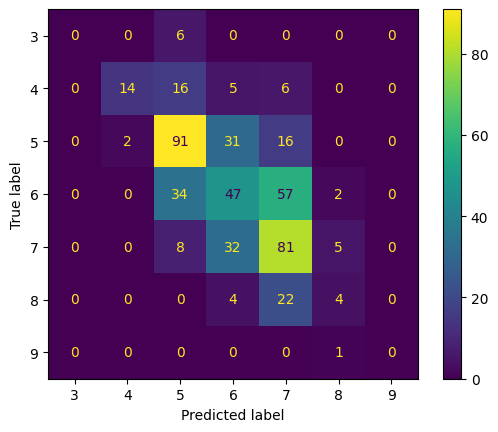

In [ ]:
predict_normal,r2_w_all,r2_all,mae_val = predict_data_odd_even(model,
                                                               model_even,
                                                               model_odd,
                                                               "3_models",
                                                               True)
display(result)
show_count_pred(predict_normal,model.classes_)

Данное решение показывает себя хуже на взвешенной метрике, но лучше на MAE, учитывая количество затрат на обучение , приоритет отдаётся базовой модели

# **Результаты**

В результате множества тестов и экспериментов, наилучший результат, который был получен - r2 - 0.65 для взвешенных данных и MAE = 0.63. Значение MAE достаточно низкое, однако r2 далеко от единицы.

Исходя из полученных результатов, можно предположить, что данные очень похожи друг на друга, поэтому модель не может чётко определить где какой класс, из-за этого в центральном квадрате матрицы ошибок слишком много ярких квадратов, показывающие, что модель ошибочно классифицирует классы 5, 6 и 7

Классы 3, 4, 8 и 9 плохо предсказываются из-за их малого количества в тренировочных данных, поэтому модель не может обучиться их определять


In [ ]:
display(result)

,r2_score->1,r2_standard->1,mae -> 0
OVR_model,0.208395,0.636555,0.659091
4_layer_model,0.312077,0.656857,0.632231
3_models,0.312077,0.628235,0.619835


В итоге из всех моделей выбирается модель 4_layer_model - базовая модель, созданная в самом начале

# **Альтернативное решение**

При возможности использования различных библиотек, модель реализовывалась бы с помощью фреймворка PyTorch

Пример реализации модели показан ниже

Основным преимуществом реализации с помощью PyTorch является возможность указывать веса классов

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Задаём параметры девайсов, на которых будут обучаться модели
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using Device:', device)
    print('Available GPUs:', torch.cuda.device_count())
else:
    device = torch.device('cpu')
    print('Using Device:', device)

Using Device: cuda
Available GPUs: 1


Проводится обработка данных, аналогичная той, что была показана в начале

In [ ]:
y_data = wine_data["quality"]
# Вычисление весов классов
class_weights = compute_class_weight(class_weight="balanced",
                                     classes=np.unique(y_data),
                                     y=y_data).astype(np.float32)
class_weights = torch.from_numpy(class_weights)

x_data = wine_data.drop(columns=["quality"])

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,
                                                    test_size=0.2,
                                                    random_state=random_seed,
                                                    stratify=y_data)

# Преобразование данных
x_train = quant_transfor.fit_transform(x_train)
x_test = quant_transfor.transform(x_test)

x_train = np.expand_dims(x_train,1)
x_test = np.expand_dims(x_test,1)
# Вычисление весов тестовых данных
sample_weights=compute_sample_weight(class_weight="balanced", y=y_test)

# Конвертация данных в тензор
x_test_t = torch.from_numpy(np.array(x_test, dtype=np.float32)).to(device)
y_test_t = torch.from_numpy(np.array(y_test, dtype=np.float32)).to(device).long()-3

# Создание класса для создания датасета
class Data(Dataset):
    def __init__(self):
        self.x=torch.from_numpy(np.array(x_train, dtype=np.float32)).to(device)
        self.y=torch.from_numpy(np.array(y_train, dtype=np.float32)).to(device).long()-3
        self.len=self.x.shape[0]

    def __getitem__(self,index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

dataset = Data()

trainloader=DataLoader(dataset=dataset,batch_size=1)

Далее создаётся модель с 5 полносвязными слоями размерами 128-256-128-64, в качестве функции активации используется сигмоида. Также используются слои dropout, чтобы снизить вероятность переобучения модели

In [ ]:
class Decoder(nn.Module):
  def __init__(self,input):
    super().__init__()
    self.sigmoid = nn.Sigmoid()
    self.conv1 = nn.Conv1d(input, 3, kernel_size=1, padding="same")
    self.conv2 = nn.Conv1d(3, input, kernel_size=1, padding="same")

  def forward(self, x):
    x = self.conv1(x)
    x = self.sigmoid(x)
    x = self.conv2(x)
    x = self.sigmoid(x)

    return x

In [ ]:
# Создание класса модели
class Network(nn.Module):
  def __init__(self,input,output):
    super().__init__()
    self.decoder = Decoder(1)
    # Функция активации
    self.sig = nn.Sigmoid()
    # Основные слои модели
    self.lay1 = nn.Linear(input,128)
    self.lay2= nn.Linear(128,256)
    self.lay3 = nn.Linear(256,128)
    self.lay4 = nn.Linear(128,64)
    self.lay5 = nn.Linear(64,output)
    # Вспомогательные слои
    self.drop1 = nn.Dropout(0.2)
    self.drop2 = nn.Dropout(0.1)

  def forward(self,x):
    x = self.decoder(x)
    x = x[:, 0, :]

    x = self.lay1(x)
    x = self.sig(x)

    x = self.lay2(x)
    x = self.sig(x)
    x = self.drop1(x)

    x = self.lay3(x)
    x = self.sig(x)
    x = self.drop2(x)

    x = self.lay4(x)
    x = self.sig(x)
    x = self.drop2(x)

    x = self.lay5(x)

    return x

input_size = len(dataset[0][0][0])
print(input_size)
output_size = y_data.nunique()
model = Network(input_size, output_size).to(device)

# Инициализируем оптимизатор и функцию ошибки
optimizer = optim.Adam(model.parameters(),lr=0.001)
loss_fn = nn.CrossEntropyLoss(weight=class_weights).to(device)

11


Пишется функция для формирования предсказаний

In [ ]:
# Функция для предсказания
def get_predict(x_test,model):
  predict_list = []
  predict = model(x_test).cpu()
  for val in predict:
    predict_list.append(np.argmax(val.detach().numpy()) + 3)

  return predict_list

Также создаётся функция, которая будет сохранять модель по двум метриками, по r2 и взвешенной r2

In [ ]:
# Сохранение моделей
def save_model(model,max_weight_r2,max_r2):
  predict = get_predict(x_test_t,model)

  # Условия для сохранения модели по взвешенной r2
  if r2_score(y_test,predict,sample_weight=sample_weights) > max_weight_r2:
    max_weight_r2 = r2_score(y_test,predict,sample_weight=sample_weights)
    torch.save(model,"/content/drive/MyDrive/Собесы/model_weight_decode_2.pt")
    print(f"weight model saved with r2 = {max_weight_r2}")
  else:
    print("weight ",r2_score(y_test,predict,sample_weight=sample_weights))

  # Условия для сохранения модели по стандартной r2
  if r2_score(y_test,predict) > max_r2:
    max_r2 = r2_score(y_test,predict)
    torch.save(model,"/content/drive/MyDrive/Собесы/model_decode_2.pt")
    print(f"model saved with r2 = {max_r2}")
  else:
    print("Standard",r2_score(y_test,predict))

  print("MAE",mae(y_test,predict))

  return max_weight_r2,max_r2

Далее пишется алгоритм обучения, который по предсказаниями вычисляет ошибку модели, по данной ошибки вычисляет градиент и используя алгоритм стахостического градиентного спуска обновляет веса модели

weight model saved with r2 = -0.0008503401360542284
model saved with r2 = -0.013781448599243351
MAE 0.8884297520661157
epoch 0
1.544545434754003
weight model saved with r2 = 2.220446049250313e-16
model saved with r2 = -0.008844201284636588
MAE 0.8863636363636364
weight  2.220446049250313e-16
Standard -0.008844201284636588
MAE 0.8863636363636364
weight  2.220446049250313e-16
Standard -0.008844201284636588
MAE 0.8863636363636364
weight model saved with r2 = 0.43579862839444716
model saved with r2 = 0.21826917518727185
MAE 0.6962809917355371
weight model saved with r2 = 0.4394550909794812
model saved with r2 = 0.2396639135505676
MAE 0.6776859504132231
epoch 5
1.3382810421503526
weight  0.43215944914551185
Standard 0.2330809171310919
MAE 0.6818181818181818
weight model saved with r2 = 0.445913528012831
model saved with r2 = 0.26599589922847
MAE 0.6652892561983471
weight  0.3857039157126265
Standard 0.2577671537041255
MAE 0.6632231404958677
weight  0.39236491344505275
model saved with r2 = 

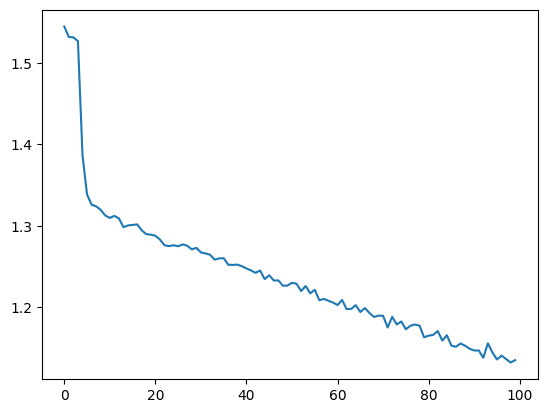

In [ ]:
# Задаём параметры обучения
epoches = 100
loss_val_list = []
max_weight_r2 = -1
max_r2 = -1

# Цикл обучения по эпохам
for epoch in range(epoches):
  extra_loss = []
  # Цикл обучения по данным
  for x,y in trainloader:
      predict = model(x)
      optimizer.zero_grad()
      loss = loss_fn(predict,y)
      # Вычисление градиента
      loss.backward()
      # Обновление весов
      optimizer.step()

      extra_loss.append(loss.item())

  loss_val_list.append(np.array(extra_loss).mean())

  max_weight_r2,max_r2 = save_model(model,max_weight_r2,max_r2)

  # Вывод информации обучения
  if epoch%5 == 0:
    print(f"epoch {epoch}")
    print(np.array(extra_loss).mean())

fig,ax = plt.subplots()
x = np.arange(len(loss_val_list))
ax.plot(x,loss_val_list, label="train loss")
ax.set_xlabel("epoch")
ax.set_ylabel("Loss val")
ax.set_title("Model loss charts")

plt.plot()

In [ ]:
# Выгрузка сохранённых моделей
model = torch.load("/content/drive/MyDrive/Собесы/model_decode.pt", weights_only=False)

r2 = 0.36474084552060404
r2_weight = 0.45879307007355796
mae = 0.5867768595041323


,Реальные,Сгенерированные
5,140,149.0
6,140,171.0
7,126,148.0
4,41,15.0
8,30,1.0
3,6,NaN
9,1,NaN


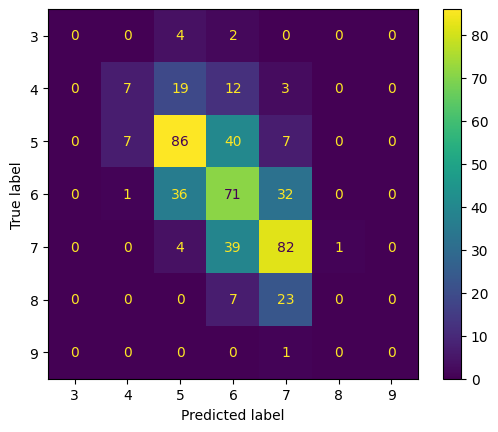

In [ ]:
predict = get_predict(x_test_t,model)

print(f"""r2 = {r2_score(y_test, predict)}
r2_weight = {r2_score(y_test,predict, sample_weight=sample_weights)}
mae = {mae(y_test,predict)}""")
show_count_pred(predict,np.arange(3,10))

Данная модель имеет более высокие показатели стандартной R2 метрики, однако значения взвешенной метрики ниже.

По матрице ошибок видно, что данная модель лучше разделяет между собой классы 5, 6 и 7, но хуже определяет классы 8 и 4

# **Улучшения**

1. Для базовой модели было проведено большое количество экспериментов с различными разбиениями модели на подмодели для различных классов. Результаты данных экспериментов были отрицательными, ни одна из моделей не показала результаты сопостовимые с базовым алгоритмом. Однако данные о винах обрабатовались как один датасет, поэтому одно из улучшений - создать две модели, которые будут обрабатывать данные раздельно. Недостаток данного метода заключается в том, что данные могут приходить не разбитые на данные о красном и белом вине, поэтому для полноценной работы данного решения необходимо будет реализовать третью модель, которая классифицирует данные на классы красные или белые вина.
2. Улучшить датасет, так как данные сильно несбалансированы, балансировка данных должна улучшить итоговые результаты. Были проведены исследования с использовнием библиотеки imbalanced-learn для oversampling'а, так как исходных данных мало, общее качество моделей упало, скорее всего из-за того, что данные стали ещё сильнее похожи друг на друга и модели не могли выделить закономерности. Поэтому в данном случае желательно проводить ручную ребалансировку с помощью добавления реальных данных для оценок с малым количеством данных
3. Дообучить модель на отдельных классах (fine-tuning модели), чтобы модель лучше определяла данные классы.
    